In [2]:
# src/collectors/reddit_collect.py
import os
import re
import json
import time
import yaml
import json
import pandas as pd
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import praw
import numpy as np
import nltk
nltk.download("vader_lexicon")
from prawcore.exceptions import Forbidden, NotFound, Redirect, RequestException, ResponseException
#!pip install scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anastasiiadobson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [8]:

# ---------- Load config ----------
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_DIR = config["data"]["raw"]

# ---------- Reddit connection ----------
def connect():
    """
    Use script auth if username/password are present (reduces 403 in some subs).
    Otherwise do app-only auth.
    """
    auth_kwargs = dict(
        client_id=config["reddit"]["client_id"],
        client_secret=config["reddit"]["client_secret"],
        user_agent=config["reddit"]["user_agent"],
    )
    if all(k in config["reddit"] for k in ("username", "password")):
        auth_kwargs["username"] = config["reddit"]["username"]
        auth_kwargs["password"] = config["reddit"]["password"]
    return praw.Reddit(**auth_kwargs)

# ---------- Subreddits ----------
SUBS = [
    "Switzerland", "nutrition", "Smoothies", "HealthyFood", "Fitness",
    "veganrecipes", "gainit", "Loseit", "xxfitness", "biohackers",
    "Supplements", "health", "HealthyEating", "Wellness", "NutritionScience",
    "keto", "vegetarian", "bodyweightfitness", "weightroom", "longevity", "Nootropics"
]

# ---------- Keyword list -> single OR query ----------
user_input = input("Enter one or more keywords separated by commas: ")
KEYWORDS = [kw.strip() for kw in user_input.split(",") if kw.strip()]

""", "protein shake", "shake",
    # protein / supplements
    "protein", "protein powder", "whey", "creatine", "supplements",
    # micronutrients
    "micronutrients", "vitamins", "minerals", "iron", "magnesium", "vitamin D", "omega-3",
    # longevity / biohacking
    "longevity", "anti-aging", "healthspan", "biohacking",
    # personalization
    "personalized nutrition", "food personalization", "nutrigenomics",
    "DNA diet", "tailored nutrition", "custom diet", "diet optimization",
    # metabolic framing
    "metabolic health", "optimal nutrition"
    """
QUERY = " OR ".join(KEYWORDS)   # <-- single OR query string

# ---------- Helpers ----------
def flatten(post):
    return {
        "id": post.id,
        "subreddit": str(post.subreddit),
        "title": post.title,
        "selftext": post.selftext,
        "created_utc": post.created_utc,
        "created_date": datetime.utcfromtimestamp(post.created_utc).strftime("%Y-%m-%d %H:%M:%S"),
        "score": post.score,
        "num_comments": post.num_comments,
        "url": post.url,
        "author": str(post.author) if post.author else None,
        "author_flair": post.author_flair_text,
    }

def retryable(call, *, tries=3, base_sleep=2, what="request"):
    """Run a PRAW call with simple exponential backoff on transient errors."""
    for i in range(tries):
        try:
            return call()
        except (RequestException, ResponseException) as e:
            wait = base_sleep * (2 ** i)
            print(f"  ! Transient {what} error ({e}); retry {i+1}/{tries} in {wait}s")
            time.sleep(wait)
    return call()  # last attempt (let exceptions bubble)

# ---------- Collectors ----------
def collect_new(reddit, subs, limit=50, sleep_s=1.5):
    out, counts = [], defaultdict(int)
    for sub in subs:
        try:
            print(f"Fetching NEW from r/{sub} (limit={limit}) …")
            subreddit = reddit.subreddit(sub)
            def _iter():
                return subreddit.new(limit=limit)
            for submission in retryable(_iter, what=f"search:r/{sub}"):
                flat = flatten(submission)
                content = (flat["title"] + " " + flat["selftext"]).lower()
                if any(k in content for k in KEYWORDS):
                    out.append(flat)
                    counts[sub] += 1
            time.sleep(sleep_s)
        except (Forbidden, NotFound, Redirect):
            print(f"  ! Skipped r/{sub} (forbidden/not found/redirect)")
        except Exception as e:
            print(f"  ! Error r/{sub} NEW: {e}")
    return out, counts

def collect_search(reddit, subs, query_or_queries, limit=80, sleep_s=1.8):
    """
    Accepts either a single OR-string (preferred) or a list of query strings.
    If a list is given, each query is run separately.
    """
    # normalize to list
    if isinstance(query_or_queries, str):
        queries = [query_or_queries]
    else:
        queries = list(query_or_queries)

    out, counts = [], defaultdict(int)
    for sub in subs:
        for q in queries:
            try:
                print(f"Searching r/{sub} for: {q[:100]}…")
                subreddit = reddit.subreddit(sub)
                def _iter():
                    return subreddit.search(query=q, sort="new", limit=limit)
                for submission in retryable(_iter, what=f"search:r/{sub}"):
                    out.append(flatten(submission))
                    counts[sub] += 1
                time.sleep(sleep_s)
            except (Forbidden, NotFound, Redirect):
                print(f"  ! Skipped r/{sub} (forbidden/not found/redirect)")
                break  # don't keep querying this sub
            except Exception as e:
                print(f"  ! Error r/{sub} SEARCH: {e}")
                # continue to next query
    return out, counts

# ---------- Main ----------
if __name__ == "__main__":
    print(f"Subreddits loaded ({len(SUBS)}): {SUBS}")
    reddit = connect()

    # 1) Latest posts
    latest_posts, new_counts = collect_new(reddit, SUBS, limit=50)

    # 2) Query-based search (single OR query string)
    query_posts, search_counts = collect_search(reddit, SUBS, QUERY, limit=60)

    # Combine & de-duplicate
    seen, all_posts = set(), []
    for p in latest_posts + query_posts:
        if p["id"] not in seen:
            seen.add(p["id"])
            all_posts.append(p)

    # Summaries
    print("\n--- Per-subreddit counts ---")
    all_counts = defaultdict(int)
    for k, v in new_counts.items():
        all_counts[k] += v
    for k, v in search_counts.items():
        all_counts[k] += v
    for sub in sorted(all_counts, key=all_counts.get, reverse=True):
        print(f"  r/{sub:<18} {all_counts[sub]:>4}")

    print(f"\n✅ Collected {len(all_posts)} unique posts across {len(SUBS)} subreddits.")


    df = pd.DataFrame(all_posts)
    
    # Manual filtering to ensure keyword is *actually* in text
    def mentions_keywords(text):
        content = text.lower()
        return any(k in content for k in KEYWORDS)

    df["mentions_keyword"] = df.apply(
        lambda row: mentions_keywords((row.get("title") or "") + " " + (row.get("selftext") or "")),
        axis=1
    )
    df_filtered = df[df["mentions_keyword"]]
    # Final cleaning / selecting useful columns
    df_clean = df_filtered[[
        "id", "subreddit", "title", "selftext", "created_date", "url"
    ]]
    def slugify_keywords(keywords):
        return "_".join(re.sub(r'\W+', '', k.lower()) for k in keywords[:1])  # first 1 keyword only

    keyword_slug = slugify_keywords(KEYWORDS)

    out_csv_path = os.path.join(RAW_DIR, f"reddit_posts_{keyword_slug}.csv")
    df_clean.to_csv(out_csv_path, index=False)

    print(f"✅ Saved {len(df_clean)} filtered posts to CSV: {out_csv_path}")
    

Subreddits loaded (21): ['Switzerland', 'nutrition', 'Smoothies', 'HealthyFood', 'Fitness', 'veganrecipes', 'gainit', 'Loseit', 'xxfitness', 'biohackers', 'Supplements', 'health', 'HealthyEating', 'Wellness', 'NutritionScience', 'keto', 'vegetarian', 'bodyweightfitness', 'weightroom', 'longevity', 'Nootropics']
Fetching NEW from r/Switzerland (limit=50) …
Fetching NEW from r/nutrition (limit=50) …
Fetching NEW from r/Smoothies (limit=50) …
Fetching NEW from r/HealthyFood (limit=50) …
Fetching NEW from r/Fitness (limit=50) …
Fetching NEW from r/veganrecipes (limit=50) …
Fetching NEW from r/gainit (limit=50) …
Fetching NEW from r/Loseit (limit=50) …
Fetching NEW from r/xxfitness (limit=50) …
Fetching NEW from r/biohackers (limit=50) …
Fetching NEW from r/Supplements (limit=50) …
Fetching NEW from r/health (limit=50) …
Fetching NEW from r/HealthyEating (limit=50) …
Fetching NEW from r/Wellness (limit=50) …
Fetching NEW from r/NutritionScience (limit=50) …
  ! Skipped r/NutritionScience (f

In [55]:
print("Total posts mentioning smoothies:", len(df_clean))
print("Posts per subreddit:", df_clean['subreddit'].value_counts())


Total posts mentioning smoothies: 689
Posts per subreddit: subreddit
Health               58
HealthyFood          55
bodyweightfitness    53
vegetarian           53
loseit               50
healthyeating        50
Fitness              49
Supplements          47
nutrition            47
Biohackers           47
gainit               45
xxfitness            44
keto                 43
veganrecipes         28
weightroom           16
Smoothies             2
Switzerland           2
Name: count, dtype: int64


In [4]:
import pandas as pd
import glob
import os
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# ---------- Setup ----------
data_path = "../data/raw/"
output_path = "../data/processed/processed_posts.csv"
sid = SentimentIntensityAnalyzer()

# ---------- Load and Process ----------
all_files = glob.glob(os.path.join(data_path, "*.csv"))
df_list = []

for file in all_files:
    # Extract keyword from filename
    keyword = os.path.basename(file).replace("reddit_posts_", "").replace(".csv", "")
    
    # Load file
    df = pd.read_csv(file)
    if df.empty:
        continue  # skip empty CSVs
    
    # Add metadata
    df["keyword"] = keyword.capitalize()
    df["source"] = "Reddit"
    
    # Sentiment text (if columns exist)
    if "title" in df.columns or "selftext" in df.columns:
        df["title"] = df["title"].fillna("") if "title" in df.columns else ""
        df["selftext"] = df["selftext"].fillna("") if "selftext" in df.columns else ""
        df["text"] = df["title"].astype(str) + " " + df["selftext"].astype(str)
        df["sentiment_score"] = df["text"].apply(lambda x: sid.polarity_scores(str(x))["compound"])
        df["sentiment"] = pd.cut(
            df["sentiment_score"],
            bins=[-1, -0.05, 0.05, 1],
            labels=["Negative", "Neutral", "Positive"]
        )
    
    # Optional: parse dates
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
        df["month"] = df["date"].dt.to_period("M").astype(str)
    
    df_list.append(df)
print(df_list)
# ---------- Combine ----------
if df_list:
    combined_df = pd.concat(df_list, ignore_index=True)
    combined_df.to_csv(output_path, index=False)
    print(f"✅ Saved {len(combined_df)} rows to {output_path}")
else:
    print("⚠️ No valid CSVs found.")

[          id  subreddit                                              title  \
0    1mu1h8u  nutrition  What’s the healthiest way to do OMAD without e...   
1    1msdxa4  Smoothies                     Smoothie recipe feedback/ideas   
2    1mtp3vq     gainit  Male 5'7" 17 years old, 59kg to 71kg. 2 years ...   
3    1mgu1m2     gainit                    M32/68kg -> 73kg/5’11” (3years)   
4    1mfbkmm     gainit  5'10: 120 -> 210 -> 170 ->174:  26M, 6 Year Jo...   
..       ...        ...                                                ...   
478  1615wjd  longevity  Common supplements may reverse age-related hea...   
479   sdg3cc  longevity  Lifespan with Dr. David Sinclair episode #4 - ...   
480   q40w1m  longevity  What is the correspondence between lifespan of...   
481   ohocpz  longevity  Just a reminder to people who are taking longe...   
482   ohh7el  longevity  How much productivity has there been in 'geros...   

                                              selftext        

In [42]:
# Step 1: Imports
import pandas as pd
from pathlib import Path
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Step 2: Download sentiment model
nltk.download("vader_lexicon")
sid = SentimentIntensityAnalyzer()

# Step 3: Define paths and file names
global_path = Path("../data/raw")
words = ["smoothie", "longevity", "supplements", "coffee", "junkfood", "intermittentfasting"]
files = ["reddit_posts_" + word + ".csv" for word in words]

# Step 4: Load and process each CSV
all_dfs = []
for file in files:
    keyword = file.split("reddit_posts_")[1].replace(".csv", "")
    path = global_path / file
    df = pd.read_csv(path)
    
    df["keyword"] = keyword.capitalize()
    df["source"] = "Reddit"
    df["text"] = df["title"].fillna("") + " " + df["selftext"].fillna("")
    
    # Apply sentiment analysis
    df["sentiment_score"] = df["text"].apply(lambda x: sid.polarity_scores(x)["compound"])
    df["sentiment"] = pd.cut(
        df["sentiment_score"],
        bins=[-1, -0.05, 0.05, 1],
        labels=["Negative", "Neutral", "Positive"]
    )
    
    # Format dates
    df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
    df = df.dropna(subset=["created_date"])
    df["month"] = df["created_date"].dt.to_period("M").dt.to_timestamp()
    
    all_dfs.append(df)

# Step 5: Combine all into one DataFrame
df_all = pd.concat(all_dfs, ignore_index=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/anastasiiadobson/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [43]:
print(df_all.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'created_date', 'url',
       'keyword', 'source', 'text', 'sentiment_score', 'sentiment', 'month'],
      dtype='object')


In [44]:
df_all = df_all[df_all["month"] >= "2017-01-01"].copy()

In [45]:
"GROUPBY MONTH,BY SUBREDDIT,KEYWORD"
import numpy as np
import pandas as pd

# Ensure month is datetime
if not np.issubdtype(df_all["month"].dtype, np.datetime64):
    df_all["month"] = pd.to_datetime(df_all["month"], errors="coerce")

# 1) Per-subreddit, per-keyword, per-month: raw counts + sentiment sums/means
df_grouped = (
    df_all.groupby(["subreddit", "keyword", "month"])
          .agg(
              post_count=("sentiment_score", "size"),
              sent_mean=("sentiment_score", "mean"),
          )
          .reset_index()
)

# 2) Monthly total across ALL subreddits (for debiasing)
df_month_totals = (
    df_all.groupby("month")
          .agg(total_posts=("sentiment_score", "size"))
          .reset_index()
)

# 3) Merge total & compute global share
df_grouped = df_grouped.merge(df_month_totals, on="month", how="left")
df_grouped["share_of_global"] = df_grouped["post_count"] / df_grouped["total_posts"]
df_grouped["share_global_weighted_net"] = df_grouped["share_of_global"] * df_grouped["sent_mean"]

print(df_grouped)

       subreddit              keyword      month  post_count  sent_mean  \
0     Biohackers               Coffee 2025-06-01           3   0.398467   
1     Biohackers               Coffee 2025-07-01          34   0.348835   
2     Biohackers               Coffee 2025-08-01          21   0.431752   
3     Biohackers  Intermittentfasting 2025-01-01           7   0.125500   
4     Biohackers  Intermittentfasting 2025-02-01           4   0.939350   
...          ...                  ...        ...         ...        ...   
1800   xxfitness          Supplements 2025-04-01           3   0.951933   
1801   xxfitness          Supplements 2025-05-01           2   0.950800   
1802   xxfitness          Supplements 2025-06-01           2   0.950800   
1803   xxfitness          Supplements 2025-07-01           3   0.966600   
1804   xxfitness          Supplements 2025-08-01           3   0.796467   

      total_posts  share_of_global  share_global_weighted_net  
0             158         0.018987 

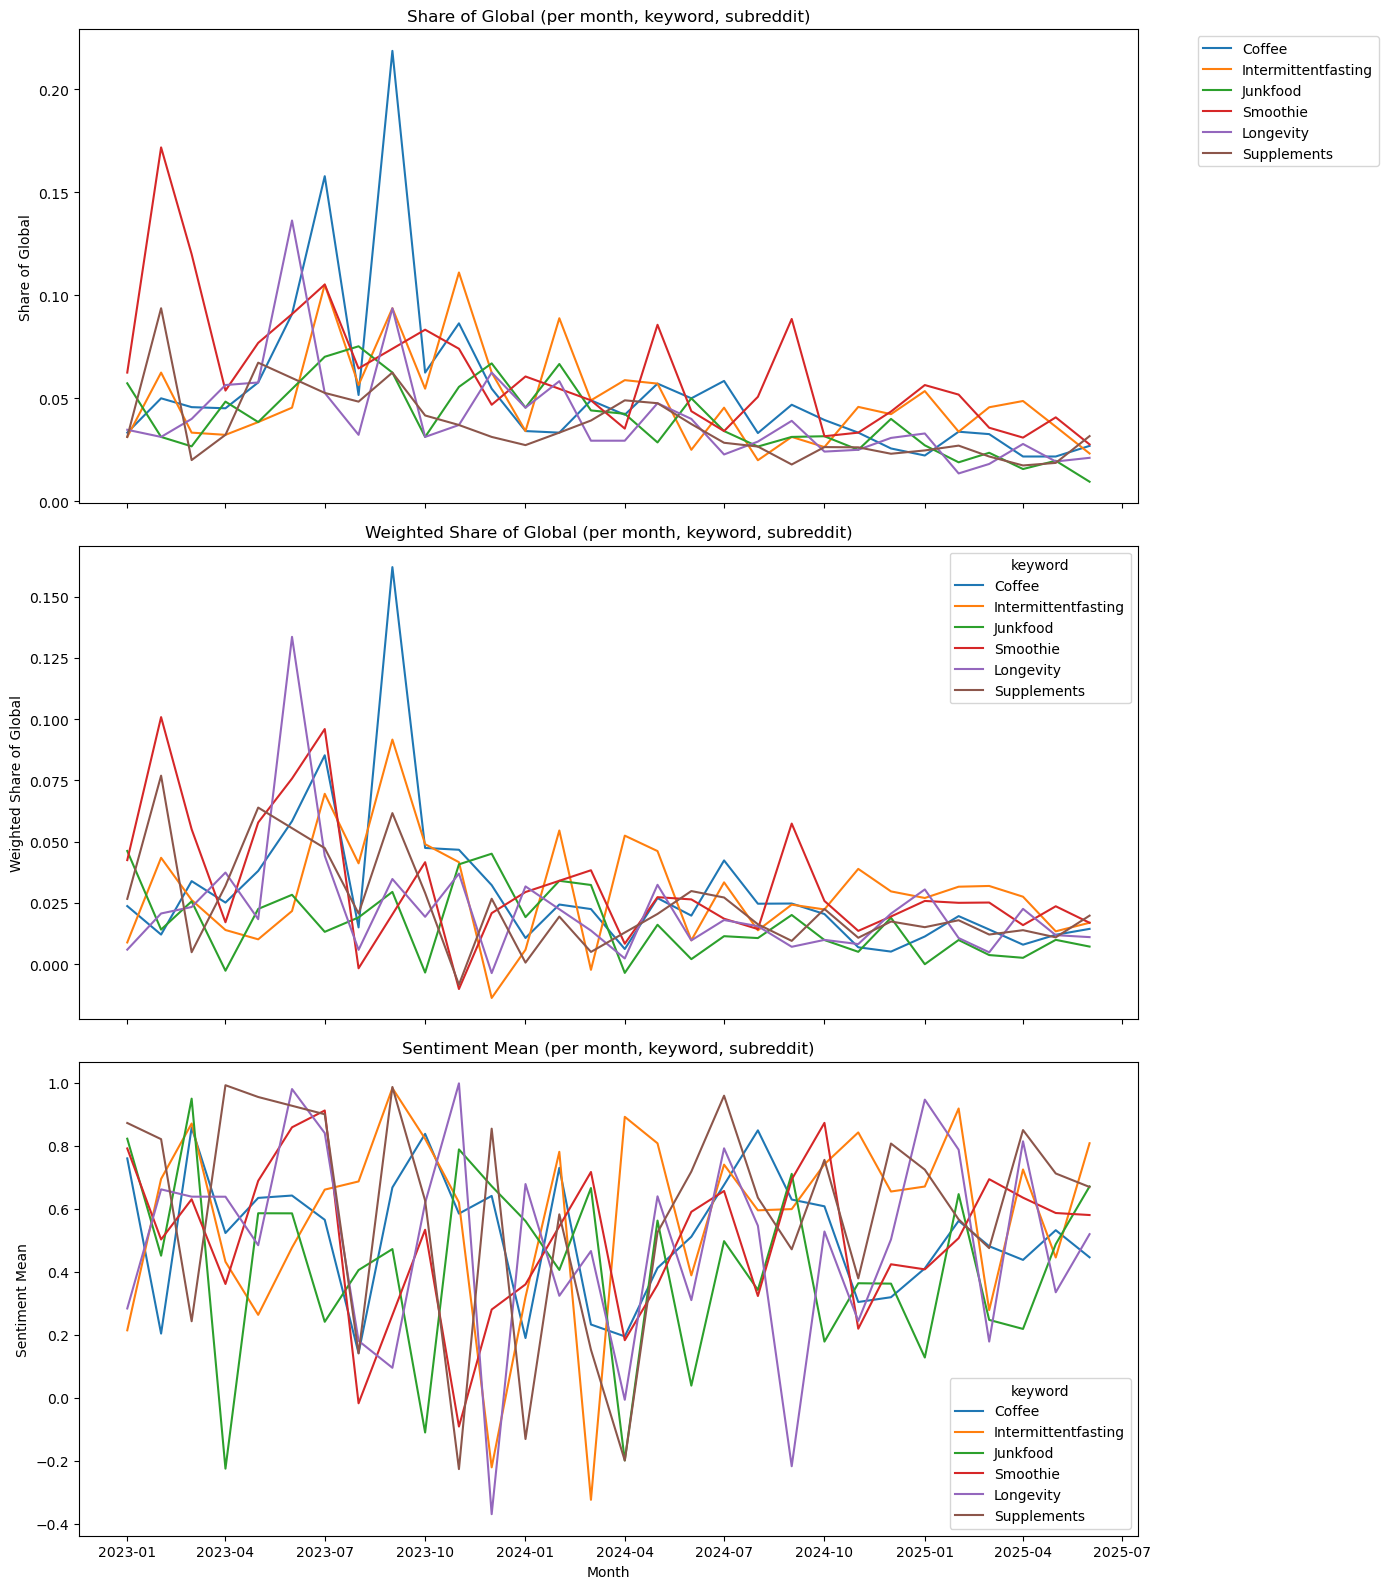

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

df_grouped = df_grouped[
    (df_grouped["month"] >= "2023-01-01") & 
    (df_grouped["month"] < "2025-07-01")
].copy()
fig, axes = plt.subplots(3, 1, figsize=(14, 16), sharex=True)

# 1) Plot share_of_global
sns.lineplot(
    data=df_grouped,
    x="month",
    y="share_of_global",
    hue="keyword",
    ci=None,
    errorbar=None,
    ax=axes[0]
)
axes[0].set_title("Share of Global (per month, keyword, subreddit)")
axes[0].set_ylabel("Share of Global")
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2) Plot weighted ratio
sns.lineplot(
    data=df_grouped,
    x="month",
    y="share_global_weighted_net",
    hue="keyword",
    ci=None,
    errorbar=None,
    ax=axes[1]
)
axes[1].set_title("Weighted Share of Global (per month, keyword, subreddit)")
axes[1].set_ylabel("Weighted Share of Global")

# 3) Plot sentiment
sns.lineplot(
    data=df_grouped,
    x="month",
    y="sent_mean",
    hue="keyword",
    ci=None,
    errorbar=None,
    ax=axes[2]
)
axes[2].set_title("Sentiment Mean (per month, keyword, subreddit)")
axes[2].set_ylabel("Sentiment Mean")
axes[2].set_xlabel("Month")

plt.tight_layout()
plt.show()

In [47]:
print(df_grouped)

       subreddit              keyword      month  post_count  sent_mean  \
0     Biohackers               Coffee 2025-06-01           3   0.398467   
3     Biohackers  Intermittentfasting 2025-01-01           7   0.125500   
4     Biohackers  Intermittentfasting 2025-02-01           4   0.939350   
5     Biohackers  Intermittentfasting 2025-03-01          13   0.842392   
6     Biohackers  Intermittentfasting 2025-04-01           7   0.931100   
...          ...                  ...        ...         ...        ...   
1798   xxfitness          Supplements 2025-02-01           3   0.966633   
1799   xxfitness          Supplements 2025-03-01           4   0.959000   
1800   xxfitness          Supplements 2025-04-01           3   0.951933   
1801   xxfitness          Supplements 2025-05-01           2   0.950800   
1802   xxfitness          Supplements 2025-06-01           2   0.950800   

      total_posts  share_of_global  share_global_weighted_net  
0             158         0.018987 

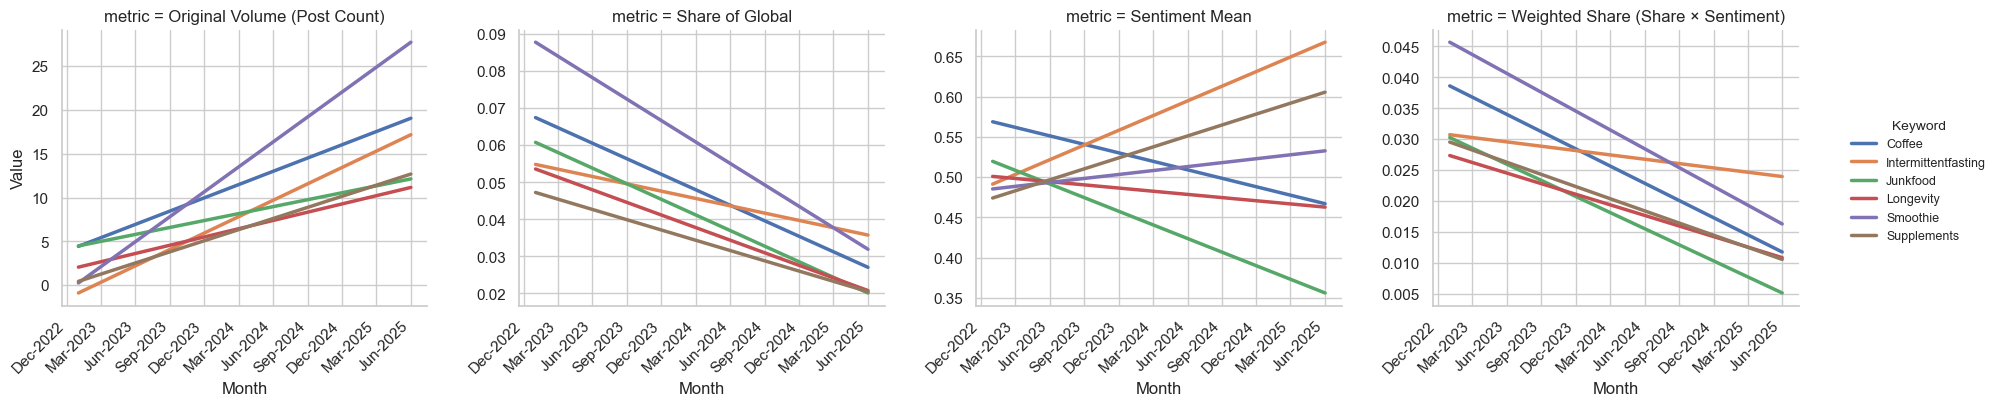

In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ----------------------------
# 0) Prep once
# ----------------------------
df_plot = df_grouped.copy()
df_plot["month"] = pd.to_datetime(df_plot["month"], errors="coerce")
df_plot = (
    df_plot.dropna(subset=["month"])
           .sort_values(["month", "keyword", "subreddit"])
)
# time window
mask = (df_plot["month"] >= "2023-01-01") & (df_plot["month"] < "2025-07-01")
df_plot = df_plot[mask]

# ----------------------------
# helper: add simple per-keyword trend
# ----------------------------
def add_trend_per_keyword(df, ycol, deg=1):
    out = []
    for kw, g in df.groupby("keyword", sort=False):
        g = g.sort_values("month").copy()
        x = g["month"].map(pd.Timestamp.toordinal).to_numpy()
        y = g[ycol].to_numpy()
        if np.isfinite(y).sum() >= (deg + 1):
            coef = np.polyfit(x, y, deg)
            g[f"{ycol}_trend"] = np.poly1d(coef)(x)
        else:
            g[f"{ycol}_trend"] = y
        out.append(g)
    return pd.concat(out, ignore_index=True)

# ----------------------------
# 1) Original volume per month per keyword (sum across subreddits) + trend
# ----------------------------
df_vol = (df_plot.groupby(["month", "keyword"], as_index=False)["post_count"]
                 .sum()
                 .sort_values(["month", "keyword"]))
df_vol = add_trend_per_keyword(df_vol, "post_count", deg=1)

# ----------------------------
# 2) Trends for share/weighted/sentiment on the grouped data
# ----------------------------
df_trend = add_trend_per_keyword(df_plot, "share_of_global", deg=1)
df_trend = add_trend_per_keyword(df_trend, "share_global_weighted_net", deg=1)
df_trend = add_trend_per_keyword(df_trend, "sent_mean", deg=1)

# ----------------------------
# 3) Build tidy frame for all panels (put RAW first)
# ----------------------------
tidy_parts = []

# (A) Raw volume trend first
tidy_parts.append(
    df_vol.rename(columns={"post_count_trend": "value"})[["month", "keyword", "value"]]
          .assign(metric="Original Volume (Post Count)")
)

# (B) Ratios / weighted / sentiment
tidy_parts.append(
    df_trend.rename(columns={
        "share_of_global_trend": "value"
    })[["month", "keyword", "value"]].assign(metric="Share of Global")
)

tidy_parts.append(
    df_trend.rename(columns={
        "sent_mean_trend": "value"
    })[["month", "keyword", "value"]].assign(metric="Sentiment Mean")
)


tidy_parts.append(
    df_trend.rename(columns={
        "share_global_weighted_net_trend": "value"
    })[["month", "keyword", "value"]].assign(metric="Weighted Share (Share × Sentiment)")
)


tidy = pd.concat(tidy_parts, ignore_index=True)

# enforce facet order (raw first)
order = [
    "Original Volume (Post Count)",
    "Share of Global",
    "Sentiment Mean",
    "Weighted Share (Share × Sentiment)",
    
]
tidy["metric"] = pd.Categorical(tidy["metric"], categories=order, ordered=True)

# ----------------------------
# 4) Faceted plot (4 panels, one row)
# ----------------------------
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(
    tidy,
    col="metric",
    hue="keyword",
    col_wrap=4,                 # all in one row
    height=3.8,
    aspect=1.35,
    sharex=True,
    sharey=False
)

g.map_dataframe(sns.lineplot, x="month", y="value", estimator=None, lw=2.5)

# Month-Year ticks & rotation
locator = mdates.MonthLocator(interval=3)
formatter = mdates.DateFormatter('%b-%Y')
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    for lbl in ax.get_xticklabels():
        lbl.set_rotation(45)
        lbl.set_horizontalalignment('right')

g.set_xlabels("Month")
g.set_ylabels("Value")

# Single legend, placed closer to panels
handles, labels = g.axes.flat[0].get_legend_handles_labels()
if g._legend is not None:
    g._legend.remove()

# Move it just outside the last facet; shrink right margin a bit
g.fig.legend(
    handles, labels, title="Keyword",
    loc="center left", bbox_to_anchor=(0.90, 0.5), frameon=False, fontsize=9, title_fontsize=10
)

plt.subplots_adjust(right=0.88, wspace=0.25, hspace=0.35)
plt.show()

1. Original Volume (Post Count)
	•	Smoothie shows the steepest growth in raw post counts — it’s the dominant topic in terms of sheer volume by mid-2025.
	•	Intermittent fasting is also growing strongly, surpassing Coffee at the end.
	•	Coffee starts relatively high but grows more slowly compared to Smoothie.
	•	Longevity, Supplements, Junkfood are increasing too, but at a much smaller slope.

📌 Takeaway: Smoothie and Intermittent Fasting are “trending” strongly, while Coffee is steady but relatively less dynamic.

⸻

2. Share of Global
	•	Even though volumes are increasing for everyone, all shares are decreasing.
	•	This means that the overall “global conversation” size is expanding faster than any single keyword’s growth.
	•	Smoothie starts as the highest share but declines sharply.
	•	Intermittent fasting drops more moderately but still downward.
	•	Junkfood, Longevity, Supplements → all consistently declining in share.

📌 Takeaway: Nobody is “winning share” — competition/noise is increasing globally.

⸻

3. Sentiment Mean
	•	Smoothie and Intermittent fasting show improving sentiment over time → positive perception strengthening.
	•	Coffee sentiment is declining gradually.
	•	Junkfood shows a strong downward trend (expected, as discussions get more negative).
	•	Longevity remains fairly stable, slightly negative drift.
	•	Supplements are slightly improving.

📌 Takeaway: Smoothie + Intermittent fasting are not only growing in volume but also gaining positivity. Coffee risks losing favor.

⸻

4. Weighted Share (Share × Sentiment)
	•	Here, Smoothie and Intermittent fasting again stand out, maintaining higher levels due to positive sentiment balancing their declining global share.
	•	Coffee drops sharply because of both declining share and sentiment.
	•	Junkfood plummets — low share and worsening sentiment drag it down.
	•	Longevity and Supplements keep a middle position.

📌 Takeaway: When accounting for positivity, Smoothie and Intermittent fasting clearly lead the pack. Coffee and Junkfood are losing relevance both in share and sentiment.

⸻

✅ Overall story:
	•	Winners: Smoothie, Intermittent fasting — growing in volume, sentiment improving, resilient in weighted share.
	•	Stable/Middle: Longevity, Supplements — modest growth, neutral sentiment, not leaders but not collapsing.
	•	Losers: Coffee, Junkfood — declining sentiment + shrinking weighted share, even if raw post counts grow.


In [49]:
print(df_all.columns)
print(df_all['created_date'].min())
print(df_all['created_date'].max())

Index(['id', 'subreddit', 'title', 'selftext', 'created_date', 'url',
       'keyword', 'source', 'text', 'sentiment_score', 'sentiment', 'month'],
      dtype='object')
2017-01-07 23:00:09
2025-08-20 20:51:05


Total documents for this keyword: 719


In [118]:
# ============================================================
# BERTopic – Stable per-keyword topic modeling (CPU friendly)
# ============================================================

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

import re
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import umap
import hdbscan
from bertopic import BERTopic

# -------------------------
# 0) CONFIG
# -------------------------
KEYWORDS = ["Smoothie",  "Longevity"]
MAX_DOCS_PER_KEYWORD = 3000
EMBED_MODEL = "sentence-transformers/all-MiniLM-L6-v2"
LANG = "english"
OUT_DIR = "outputs_topics"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------
# 1) LOAD + PREP DATAFRAME
# -------------------------
# You must already have `df_all` loaded (columns: keyword, title, selftext, created_date)
df = df_all.copy()
df["created_date"] = pd.to_datetime(df["created_date"], errors="coerce")
df = df.dropna(subset=["created_date"])
df = df[(df["created_date"] >= "2023-01-01") & (df["created_date"] < "2025-07-01")].copy()

# Merge and clean text
def basic_clean(s: str) -> str:
    s = str(s).lower()
    s = re.sub(r"http\S+|www\.\S+", " ", s)
    s = re.sub(r"[^a-z0-9\s\-']", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

for col in ["title", "selftext"]:
    if col not in df.columns:
        df[col] = ""
df["text"] = (df["title"].fillna("") + " " + df["selftext"].fillna("")).map(basic_clean)
df = df.replace({"": np.nan}).dropna(subset=["text"])

# -------------------------
# 2) BUILD MODELS
# -------------------------
def make_vectorizer(n_docs: int) -> CountVectorizer:
    min_df_abs = max(1, min(10, int(0.005 * max(n_docs, 1))))
    if n_docs < 100:
        max_df_val = max(min_df_abs + 1, n_docs)
    else:
        max_df_val = 0.90
    print(f"min_df = {min_df_abs}, max_df = {max_df_val}, docs = {n_docs}")
    return CountVectorizer(
        stop_words=LANG,
        ngram_range=(1, 2),
        min_df=min_df_abs,
        max_df=max_df_val,
        max_features=20000
    )

umap_model = umap.UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine",
    low_memory=True,
    random_state=42
)

hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=15,
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

def build_topic_model(vectorizer_model: CountVectorizer, use_embeddings=True):
    return BERTopic(
        embedding_model=(EMBED_MODEL if use_embeddings else None),
        vectorizer_model=vectorizer_model,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        language=LANG,
        calculate_probabilities=False,
        verbose=True,
        nr_topics=None
    )

# -------------------------
# 3) RUN BERTopic PER KEYWORD
# -------------------------
def run_bertopic_for_keyword(df_kw: pd.DataFrame, kw: str):
    docs = df_kw["text"].tolist()
    if len(docs) > MAX_DOCS_PER_KEYWORD:
        docs = docs[:MAX_DOCS_PER_KEYWORD]

    vec = make_vectorizer(len(docs))

    try:
        tm = build_topic_model(vec, use_embeddings=True)
        topics, _ = tm.fit_transform(docs)
    except Exception as e:
        print(f"[{kw}] Embedding run failed ({e}). Trying fallback…")
        tm = build_topic_model(vec, use_embeddings=False)
        topics, _ = tm.fit_transform(docs)

    info = tm.get_topic_info()
    info.to_csv(f"{OUT_DIR}/topics_{kw}.csv", index=False)

    # Save top words per topic
    rows = []
    for tid in info["Topic"]:
        if tid == -1:
            continue
        top_words = ", ".join([w for w, _ in tm.get_topic(tid)[:15]])
        rows.append({"keyword": kw, "topic_id": tid, "top_words": top_words})
    
    # Save representative docs
    rep_docs = []
    for tid in info["Topic"].head(10):
        if tid == -1:
            continue
        sample = tm.get_representative_docs(tid)[:5]
        rep_docs.append({"keyword": kw, "topic_id": tid, "sample_docs": sample})
    
    print(f"[{kw}] Topics: {len(info) - (1 if -1 in info['Topic'].values else 0)}")
    return tm, topics

# -------------------------
# 4) EXECUTE ALL
# -------------------------
models = {}
# Collect all annotated rows
all_df = []

for kw in KEYWORDS:
    df_kw = df[df["keyword"].str.lower() == kw.lower()].copy()
    model, topics = run_bertopic_for_keyword(df_kw, kw)
    df_kw["topic"] = topics
    df_kw["keyword"] = kw  # ensure keyword is preserved
    all_df.append(df_kw)   # accumulate

# Combine all keyword rows
df_bert = pd.concat(all_df, ignore_index=True)

print("\nDone. Check the 'outputs_topics' folder for:")
print("- topics_<kw>.csv")


2025-08-21 19:17:36,319 - BERTopic - Embedding - Transforming documents to embeddings.


min_df = 1, max_df = 0.9, docs = 399


Batches: 100%|██████████| 13/13 [00:02<00:00,  4.54it/s]
2025-08-21 19:17:42,055 - BERTopic - Embedding - Completed ✓
2025-08-21 19:17:42,055 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-21 19:17:42,621 - BERTopic - Dimensionality - Completed ✓
2025-08-21 19:17:42,622 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-21 19:17:42,630 - BERTopic - Cluster - Completed ✓
2025-08-21 19:17:42,632 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-21 19:17:42,712 - BERTopic - Representation - Completed ✓
2025-08-21 19:17:42,780 - BERTopic - Embedding - Transforming documents to embeddings.


[Smoothie] Topics: 8
min_df = 1, max_df = 0.9, docs = 198


Batches: 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]
2025-08-21 19:17:47,460 - BERTopic - Embedding - Completed ✓
2025-08-21 19:17:47,461 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-21 19:17:47,702 - BERTopic - Dimensionality - Completed ✓
2025-08-21 19:17:47,702 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-21 19:17:47,706 - BERTopic - Cluster - Completed ✓
2025-08-21 19:17:47,707 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-21 19:17:47,756 - BERTopic - Representation - Completed ✓


[Longevity] Topics: 5

Done. Check the 'outputs_topics' folder for:
- topics_<kw>.csv


In [138]:
print(df_kw)

           id          subreddit  \
791   1kvy5jo        Switzerland   
792   1g5ooqp        Switzerland   
796   1lklxig          nutrition   
797   1kdigfk          nutrition   
798   1jw5jmb          nutrition   
...       ...                ...   
1244  105xdvy  bodyweightfitness   
1265  117dhtx         weightroom   
1275  1lojpue          longevity   
1276  1locmvp          longevity   
1277  1lob7tl          longevity   

                                                  title  \
791                      Longevity trend in Switzerland   
792              advice for buying fondue pot conquelon   
796    Eating food from publicly traded large companies   
797   Supplements & Micronutrients for Twice-Daily B...   
798   What is the most surprising natural ingredient...   
...                                                 ...   
1244                 BWSF 6x/w Push-Pull vs Upper-Lower   
1265                                    531 BtFI Review   
1275  Seeking longevity researchers 

In [119]:

print("Available keywords in df_sent_bert:", df_bert["keyword"].unique())
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Run on all posts
df_bert["sentiment"] = df_bert["text"].apply(lambda x: sentiment_pipeline(x[:512])[0]['label'])  
sentiment_summary = df_bert.groupby("topic")["sentiment"].value_counts(normalize=True).unstack().fillna(0)
print(sentiment_summary)

Available keywords in df_sent_bert: ['Smoothie' 'Longevity']


Device set to use mps:0


sentiment   LABEL_0   LABEL_1   LABEL_2
topic                                  
-1         0.169355  0.516129  0.314516
 0         0.131148  0.434426  0.434426
 1         0.185567  0.391753  0.422680
 2         0.178082  0.547945  0.273973
 3         0.218182  0.418182  0.363636
 4         0.269231  0.557692  0.173077
 5         0.111111  0.481481  0.407407
 6         0.346154  0.307692  0.346154
 7         0.333333  0.476190  0.190476


In [120]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import textwrap

# Load the full DataFrame with original posts and topic assignments
df_bert_kw = df_bert[df_bert["topic"] != -1]  # ignore outliers
df_bert_kw["topic"] = df_bert_kw["topic"].astype(int)
print(df_bert_kw.columns)
df_sent_bert = df_bert_kw.copy()

Index(['id', 'subreddit', 'title', 'selftext', 'created_date', 'url',
       'keyword', 'source', 'text', 'sentiment_score', 'sentiment', 'month',
       'topic'],
      dtype='object')


In [121]:
print(df_sent_bert.columns)

Index(['id', 'subreddit', 'title', 'selftext', 'created_date', 'url',
       'keyword', 'source', 'text', 'sentiment_score', 'sentiment', 'month',
       'topic'],
      dtype='object')


In [123]:
print(df_sent_bert)

          id          subreddit  \
2    1lh0del          nutrition   
4    1le0rer          nutrition   
5    1l757x9          nutrition   
6    1l2ufkt          nutrition   
7    1l29taf          nutrition   
..       ...                ...   
592  105xdvy  bodyweightfitness   
593  117dhtx         weightroom   
594  1lojpue          longevity   
595  1locmvp          longevity   
596  1lob7tl          longevity   

                                                 title  \
2    In your opinion what is the most OP fruit? I v...   
4                                  High calorie foods?   
5                             Homemade Protein Powders   
6                  chia seeds - safe ways to consume ?   
7                                     Milk foam. Help?   
..                                                 ...   
592                 BWSF 6x/w Push-Pull vs Upper-Lower   
593                                    531 BtFI Review   
594  Seeking longevity researchers for brief interv...   

In [143]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df_sent_ana = df_sent_bert.copy()[["keyword", "topic", "sentiment_score"]]

# Ensure correct dtypes
df_sent_ana["sentiment_score"] = pd.to_numeric(df_sent_ana["sentiment_score"], errors="coerce")
df_sent_ana["topic"] = pd.to_numeric(df_sent_ana["topic"], errors="coerce").astype("Int64")

sentiment_grouped = (
    df_sent_ana
    .groupby(["keyword", "topic"])["sentiment_score"]
    .mean()
    .reset_index()
    .rename(columns={"sentiment_score": "avg_sentiment"})
)

print(sentiment_grouped)



# Load all topic label files
topic_files = glob.glob("outputs_topics/topics_*.csv")
topic_dfs = []

for file in topic_files:
    kw = file.split("_")[-1].replace(".csv", "")
    df_topics = pd.read_csv(file)
    df_topics = df_topics[df_topics["Topic"] != -1]
    df_topics["keyword"] = kw.capitalize()  # align with df_sent_ana
    df_topics.rename(columns={"Topic": "topic"}, inplace=True)
    topic_dfs.append(df_topics)

# Concatenate all topic description DataFrames
df_topic_names = pd.concat(topic_dfs, ignore_index=True)

# Merge with sentiment DataFrame
df_sent_merged = pd.merge(df_sent_ana, df_topic_names, on=["keyword", "topic"], how="left")

# Show result
print(df_sent_merged.columns)
df_selected = df_sent_merged[["keyword", "topic", "sentiment_score", "Count", "Name"]]
print(df_selected.head(10))


      keyword  topic  avg_sentiment
0   Longevity      0       0.218455
1   Longevity      1       0.814377
2   Longevity      2       0.453983
3   Longevity      3       0.824263
4   Longevity      4       0.296842
5    Smoothie      0       0.493800
6    Smoothie      1       0.461446
7    Smoothie      2       0.451130
8    Smoothie      3       0.673929
9    Smoothie      4       0.446014
10   Smoothie      5       0.670922
11   Smoothie      6       0.678250
12   Smoothie      7       0.606095
Index(['keyword', 'topic', 'sentiment_score', 'Count', 'Name',
       'Representation', 'Representative_Docs'],
      dtype='object')
    keyword  topic  sentiment_score  Count                                Name
0  Smoothie      0           0.7351     78  0_recipe_banana_bowl_smoothie bowl
1  Smoothie      0          -0.4098     78  0_recipe_banana_bowl_smoothie bowl
2  Smoothie      3           0.5514     28         3_vegan_milk_recipes_really
3  Smoothie      2           0.7219     43    

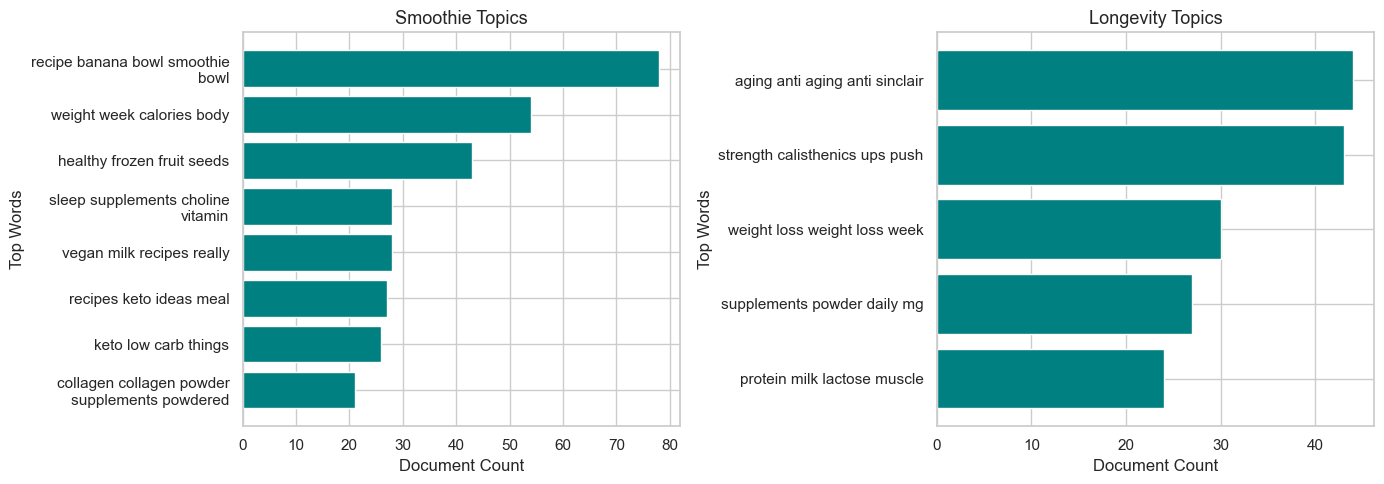

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import textwrap


# Get all relevant topic CSVs
csv_files = glob.glob("outputs_topics/topics_*.csv")

# Layout settings
n = len(csv_files)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 7, rows * 5), squeeze=False)

# Plot per file
for i, file_path in enumerate(csv_files):
    df = pd.read_csv(file_path)
    df = df[df["Topic"] != -1]
    df = df.sort_values("Count", ascending=True)

    keyword = os.path.basename(file_path).split("_")[1].split(".")[0]
    ax = axes[i // cols][i % cols]

    # Clean topic names
    df["Name"] = df["Name"].apply(lambda x: "\n".join(textwrap.wrap(x.split("_", 1)[-1].replace("_", " "), 30)))

    ax.barh(df["Name"], df["Count"], color="teal")
    ax.set_title(f"{keyword.capitalize()} Topics", fontsize=13)
    ax.set_xlabel("Document Count")
    ax.set_ylabel("Top Words")

# Hide unused axes
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols])

plt.tight_layout()
plt.show()

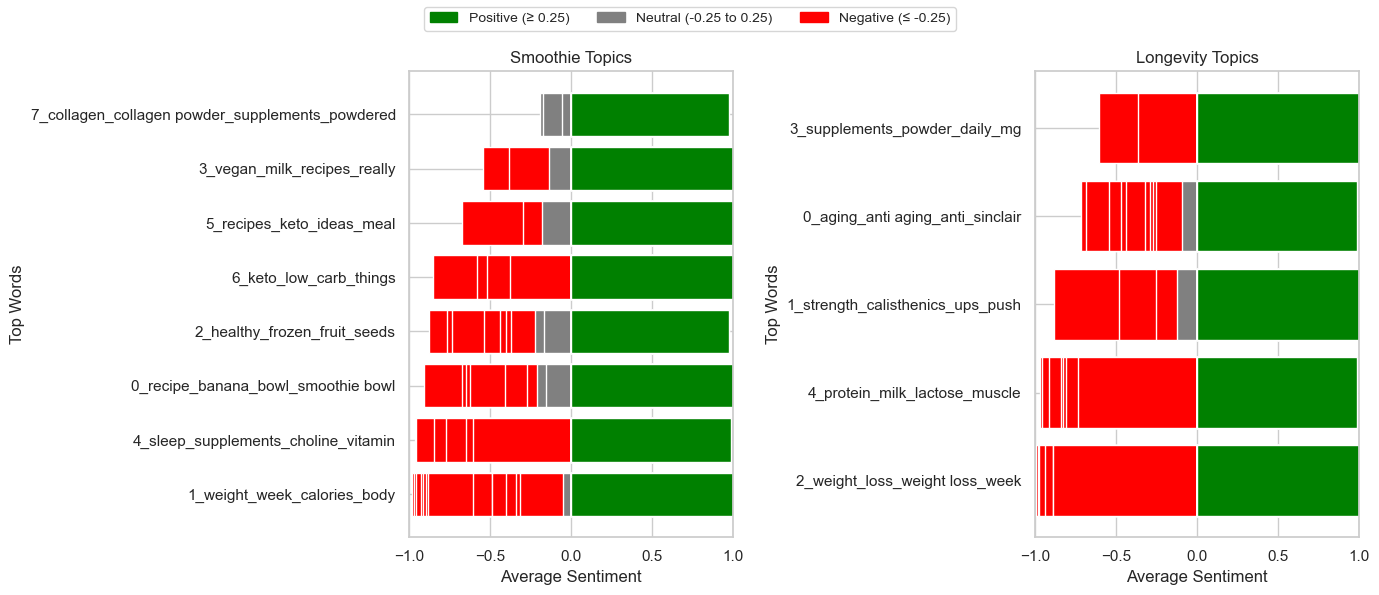

In [153]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Make a copy
df_plot = df_selected.copy()
keywords = df_plot["keyword"].unique()

# Setup subplots
fig, axes = plt.subplots(1, len(keywords), figsize=(14, 6), sharey=False)

if len(keywords) == 1:
    axes = [axes]  # ensure iterable

# Define simple color function
def get_color(score):
    if score >= 0.25:
        return "green"
    elif score <= -0.25:
        return "red"
    else:
        return "gray"

# Plot each keyword
for ax, kw in zip(axes, keywords):
    df_kw = df_plot[df_plot["keyword"] == kw].copy()
    df_kw = df_kw.sort_values("sentiment_score", ascending=True)
    df_kw["color"] = df_kw["sentiment_score"].apply(get_color)

    # Bar plot with custom colors
    ax.barh(
        y=df_kw["Name"],
        width=df_kw["sentiment_score"],
        color=df_kw["color"]
    )

    ax.set_xlim(-1, 1)
    ax.set_title(f"{kw} Topics")
    ax.set_xlabel("Average Sentiment")
    ax.set_ylabel("Top Words")

# Add a custom legend
legend_patches = [
    mpatches.Patch(color="green", label="Positive (≥ 0.25)"),
    mpatches.Patch(color="gray", label="Neutral (-0.25 to 0.25)"),
    mpatches.Patch(color="red", label="Negative (≤ -0.25)")
]
fig.legend(handles=legend_patches, loc="upper center", ncol=3, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for legend
plt.show()

📌 Insights from Sentiment Analysis of Smoothie Topics

Our sentiment analysis reveals clear trends in how different smoothie-related topics are perceived:

✅ High-Performing Topics (Positive Sentiment)
	•	Collagen & Supplements (collagen_collagen powder_supplements_powdered)
→ Strong interest in smoothies that support beauty and wellness (e.g., skin health).
	•	Keto Recipes (recipes_keto_ideas_meal)
→ Positive engagement with keto-friendly and meal-replacement smoothies.
	•	Vegan Milk Recipes (vegan_milk_recipes_really)
→ Positive sentiment indicates growing interest in plant-based options.

⚖️ Neutral/Moderate Topics
	•	Frozen Fruit & Seeds (healthy_frozen_fruit_seeds)
→ Perceived as healthy but common; potential to elevate with unique superfoods.
	•	Banana Bowl Recipes (recipe_banana_bowl_smoothie bowl)
→ Well-known, but possibly seen as too basic or repetitive.

❌ Low-Performing Topics (Negative Sentiment)
	•	Weight & Calories (weight_week_calories_body)
→ Language around weight may feel pressuring or negative to users.
	•	Sleep Supplements (sleep_supplements_choline_vitamin)
→ Users may be skeptical of sleep-related claims in smoothies.
	•	Low-Carb Keto Variants (keto_low_carb_things)
→ Possible confusion or unmet expectations around low-carb product messaging.

⸻

💡 Key Takeaways
	•	Double down on collagen, keto recipes, and plant-based options in both product development and content.
	•	Avoid overpromising effects like weight loss or better sleep unless claims are credible and clear.
	•	Refresh basic themes (like banana bowls or frozen fruit) with premium ingredients or better visual appeal.
	•	Focus on empowering, feel-good language instead of restrictive or clinical health messaging.

⸻


📌 Insights for Smoothie Business: Sentiment + Popularity Analysis

Our dual analysis combines sentiment scores and topic frequency to identify which themes are both emotionally resonant and widely discussed by users.

⸻

✅ Top Opportunities (High Sentiment + High Volume)
	•	Banana Bowl Recipes (recipe_banana_bowl_smoothie bowl)
→ Most popular topic overall. Despite slightly neutral sentiment, it’s a crowd favorite — great base for viral content or signature products.
	•	Keto Recipes (recipes_keto_ideas_meal)
→ High sentiment and strong mentions — reflects growing demand for low-carb health-conscious options.
	•	Vegan Milk Recipes (vegan_milk_recipes_really)
→ Positive tone + mid-range frequency — signals a niche with upward trend potential.

⸻

💡 Underestimated Gems (High Sentiment, Low Frequency)
	•	Collagen & Powdered Supplements
→ Low document count but strong sentiment. This could be a premium segment with high perceived value — ideal for targeted campaigns.

⸻

⚖️ Mixed/Neutral Themes
	•	Frozen Fruits & Seeds
→ Neutral sentiment, mid popularity. A solid category that can be boosted by novelty or health-claim framing (e.g. antioxidants, immunity).

⸻

❌ Caution Areas (High Mentions, Low or Negative Sentiment)
	•	Weight & Calories
→ Popular but sentiment is neutral to negative — likely due to pressure/expectation around weight loss. Use empowering or self-love framing instead.
	•	Sleep Supplements
→ Low engagement, low sentiment — seen as less credible. Avoid overstating claims in this area.

⸻

🔍 Longevity Insights (Supporting Themes)

From the longevity-oriented posts, we see strong interest in:
	•	Anti-aging and calisthenics (strong volume),
	•	Supplements and protein intake (moderate interest),
	•	But similar sentiment dynamics: users are positive about fitness and muscle, more skeptical about claims like weight loss or daily supplements.

⸻

📈 Strategic Recommendations
	1.	Prioritize:
	•	Banana bowls, keto-friendly ideas, vegan smoothies, collagen boosters.
	2.	Reframe Carefully:
	•	Weight loss → focus on energy, digestion, or feeling good.
	3.	Differentiate:
	•	Innovate around frozen fruit basics and low-carb offerings.
	4.	Educate or Avoid:
	•	Sleep/weight-related health claims — only if backed by clear science or customer success stories.

